# Machine Learning Pipeline - Feature Selection

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. Feature Engineering
3. **Feature Selection**
4. Model Training
5. Obtaining Predictions / Scoring

Our selection procedure will be focused solely on non-parametric statistical methods because they are model-agnostic. We avoid model-specific methods because:

1. They can be very computationally expensive. This project is being run on a local machine and not a distrubuted system.
2. Model-specific methods would require us to use the same model in training as we did in feature selection for consistency. This is impractical as we still have to run our data through a range of options during training before deciding on our most optimal model.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# for running statistical tests
from scipy.stats import mannwhitneyu, spearmanr, chi2_contingency

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load the train and test sets with the engineered variables
X_train = pd.read_csv('xtrain_unscaled.csv')
X_test = pd.read_csv('xtest_unscaled.csv')

In [3]:
# load the target
y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

# Feature Selection

Let's go ahead and select a subset of the most predictive features.

## Drop constant features
Constant features show the same value for all observations in the dataset and provide no information value for a machine learnign model. Recall our dataset had two constant features - Z_CostContact and Z_Revenue - which were both removed during feature engineering.

## Drop quasi-constant features
Quasi-constant features also show the same value but only for the great majority of the observations. Like constant features, they provide little, if any, information value for any model to work with.

As another sanity check, we will also check our columns for quasi-constant features and remove them.

In [4]:
# create an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:
    
    # find the predominant value, i.e. the value shared
    # by most observations
    predominant = (X_train[feature].value_counts() / float(
        len(X_train))).sort_values(ascending=False).values[0]
    
    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

In [5]:
len(quasi_constant_feat)

0

Our dataset does not have any variables with quasi-constant values.

## Statistical Tests

We will now evaluate our variables individually to select variables with a strong predictive association with our target. This process will involve non-parametric model-agnostic methods for the three distinct variable types in our dataset.

- Categorical Variables
- Discrete Variables
- Continuous Variables

All the tests are conducted at the 5% significance level.

### Categorical Variables: Chi-Squared Test

For the categorical variables, we will test for independence to see if they are associated with the target variable. 

In [6]:
# grab the categorical variables in a list
# they include binary and discrete/non-binary variables with at most 20 unique values
cat_vars = [var for var in X_train.columns
             if X_train[var].nunique()<=20]
cat_vars

['Education',
 'Marital_Status',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain']

In [7]:
# empty lists to store the p-values and test statistics
p_ls = []
chi_ls = []

for feature in cat_vars:
    
    # create contingency table
    c = pd.crosstab(y_train['Response'], X_train[feature])
    
    # chi_test
    chi = chi2_contingency(c)[0]
    p_value = chi2_contingency(c)[1]
    
    chi_ls.append(chi)
    p_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

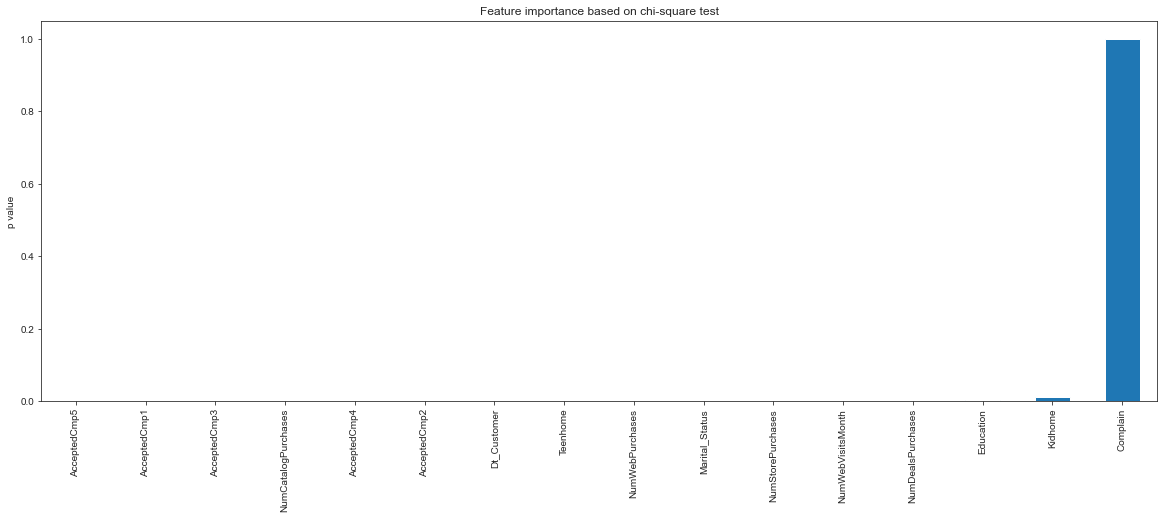

In [8]:
# plot out the p values

pd.Series(p_ls, index=cat_vars).sort_values(ascending=True).plot.bar(rot=90,figsize=(20,7))
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [9]:
# print out the p-values
pd.Series(p_ls, index=cat_vars).sort_values(ascending=True)

AcceptedCmp5           1.519800e-39
AcceptedCmp1           8.252675e-36
AcceptedCmp3           3.792543e-26
NumCatalogPurchases    1.295338e-17
AcceptedCmp4           5.910440e-15
AcceptedCmp2           3.917639e-13
Dt_Customer            2.830618e-11
Teenhome               1.371790e-10
NumWebPurchases        5.978872e-09
Marital_Status         9.788661e-07
NumStorePurchases      1.089395e-06
NumWebVisitsMonth      3.767303e-04
NumDealsPurchases      7.943778e-04
Education              4.692500e-03
Kidhome                1.197814e-02
Complain               1.000000e+00
dtype: float64

We fail to reject the null hypothesis for the Complain variable at the 5% significance level but we reject the null hypothesis for all the other categorical variables at the 5% significance level. Notice the p-value for Complain is at 100%,i.e. there is absolutely no statistical/mathematical chance it is associated with the target variable.

Let us now plot out the chi-squared values for the variables:

Text(0.5, 1.0, 'Feature importance based on chi-square test')

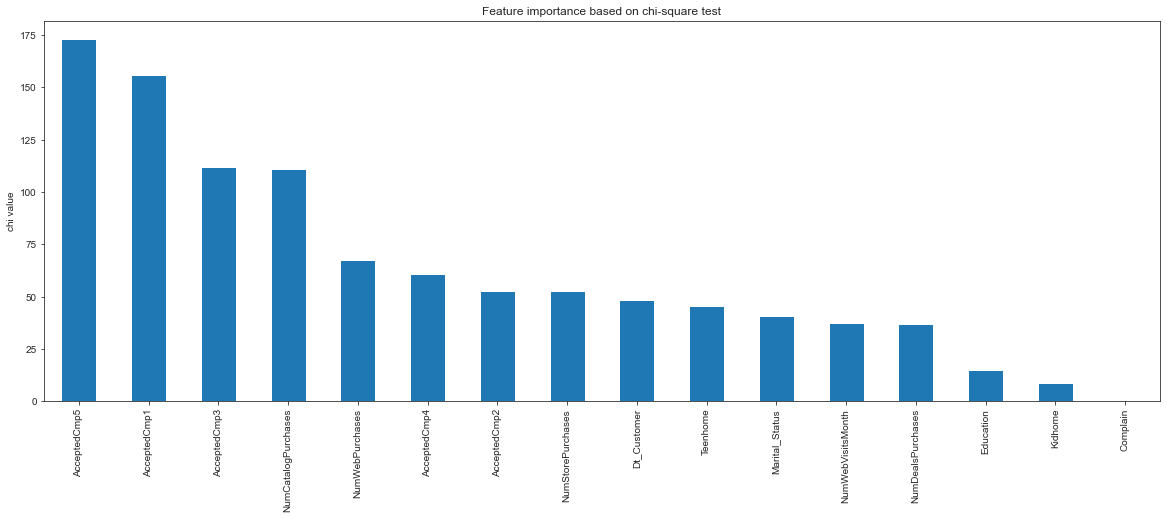

In [10]:
pd.Series(chi_ls, index=cat_vars).sort_values(ascending=False).plot.bar(rot=90,figsize=(20,7))
plt.ylabel('chi value')
plt.title('Feature importance based on chi-square test')

As expected, values with the highest chi-squared have the lowest p-values. Now that we have established that only one variable is not associated with the target, let us now observe the effect sizes of this association.

We separate the variables into binary and non-binary because the effect size caluculation for each variable type is different.

In [11]:
binary = [var for var in cat_vars
          if X_train[var].nunique()==2]
binary

['AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain']

In [12]:
# function to compute the phi score
def phi_score(chi,df):
    
    n = len(df)
    v = np.sqrt(chi / n)
    return v

Text(0.5, 1.0, 'Feature importance based on effect sizes')

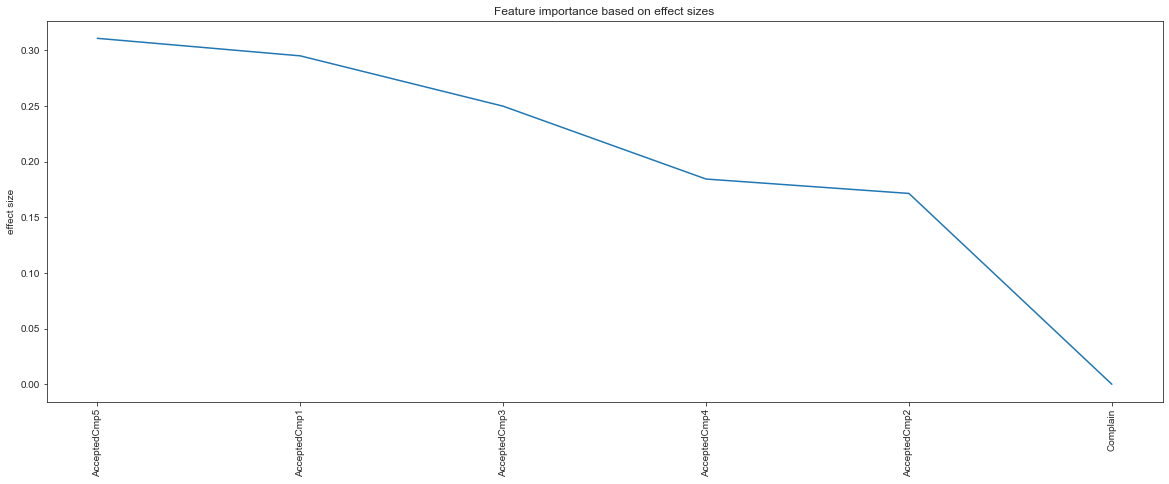

In [13]:
chi_series = pd.Series(chi_ls, index=cat_vars)

# dictionary to store the effect sizes
binary_effects = {}

# iterate over the variables
for var in binary:
    
    # pass the chi-squared value from the chi-series dictionary
    # as a variable to the phi_score function
    phi = phi_score(chi_series[var],X_train)
    
    # store the effect size in the dictionary
    binary_effects[var] = phi

# plot out the effect sizes
pd.Series(binary_effects).sort_values(ascending=False).plot.line(rot=90,figsize=(20,7))
plt.ylabel('effect size')
plt.title('Feature importance based on effect sizes')

In [14]:
pd.Series(binary_effects).sort_values(ascending=False)

AcceptedCmp5    0.310841
AcceptedCmp1    0.295096
AcceptedCmp3    0.249868
AcceptedCmp4    0.184396
AcceptedCmp2    0.171463
Complain        0.000000
dtype: float64

All the variables with p-values that violated the null hypothesis have medium effects (<=0.3). We failed to reject the null hypothesis for Complain so we don't expect a size effect from it.

NOTE: Our sample size for the YES class is very small. Therefore, it is important to make any statistical inference from these computations with sigiificant caution. The model still hasn't seen enough instances of the YES class across the various variables for us to conclude on any possible association with the target variable.

Let us now compute the effect sizes for the non-binary variables:

In [15]:
non_binary = [var for var in cat_vars
          if X_train[var].nunique()>2]
non_binary

['Education',
 'Marital_Status',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth']

In [16]:
# function to compute cramer's v
def v_score(chi,df):
    
    n = len(df)
    len_rows = len(df)
    len_cols = len(df.columns)
    dof = np.min([len_rows, len_cols])
    #dof = (len_rows - 1) * (len_cols - 1)
    v = np.sqrt(chi / (n * dof))
    return v

Text(0.5, 1.0, 'Feature importance based on effect sizes')

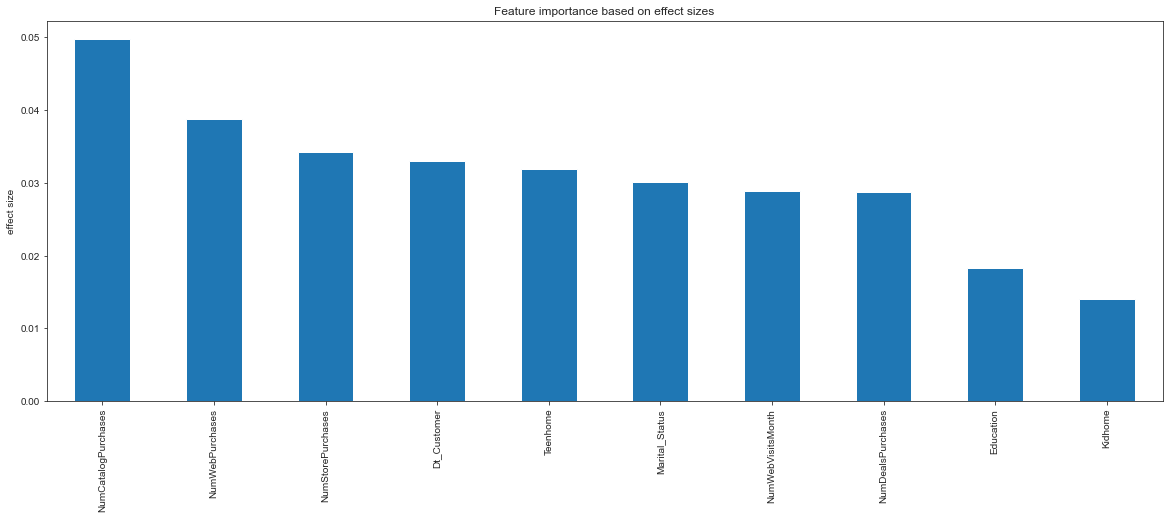

In [17]:
# dictionary to store the effect sizes
non_binary_effects = {}

# iterate over each variable
for var in non_binary:
    
    # pass the chi-squared value from the chi-series dictionary
    # as a variable to the phi_score function
    v_value = v_score(chi_series[var],X_train)
    
    # store the effect size in the dictionary
    non_binary_effects[var] = v_value

# plot out the effect sizes
pd.Series(non_binary_effects).sort_values(ascending=False).plot.bar(rot=90,figsize=(20,7))
plt.ylabel('effect size')
plt.title('Feature importance based on effect sizes')

In [18]:
# print out the effect sizes
pd.Series(non_binary_effects).sort_values(ascending=False)

NumCatalogPurchases    0.049734
NumWebPurchases        0.038752
NumStorePurchases      0.034243
Dt_Customer            0.032928
Teenhome               0.031841
Marital_Status         0.030093
NumWebVisitsMonth      0.028840
NumDealsPurchases      0.028656
Education              0.018301
Kidhome                0.014055
dtype: float64

All the non-binary variables have small effect sizes even though they have low p-values that violate the assumption of independence. Selecting this features won't provide any information value to our model.

### Continuous Variables: Mann-Whitney U Test

For the continuous variables, we will test for a statistical difference in the sample means at the 5% significance level using the Mann-Whitney U nonparametric test. Recall we concluded our continuous variables were not normally distributed in our data analysis notebook.

In [19]:
cont_vars = [var for var in X_train.columns
             if X_train[var].nunique()>20]
cont_vars

['Year_Birth',
 'Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

In [20]:
# concat the target with the independent variables
train = pd.concat([X_train,y_train],axis=1)

# empty dictionaries to hold the p values from the test
p_ls_mann = {}

# iterate over the continuous variables
for var in cont_vars:
    
    # separate the two samples from the target for each variable
    data_1 = train[train['Response']==0][var]
    data_2 = train[train['Response']==1][var]
    
    # mann-whitney u test
    stat, p_mann = mannwhitneyu(data_1,data_2)
    p_ls_mann[var] = p_mann

Text(0, 0.5, 'p value')

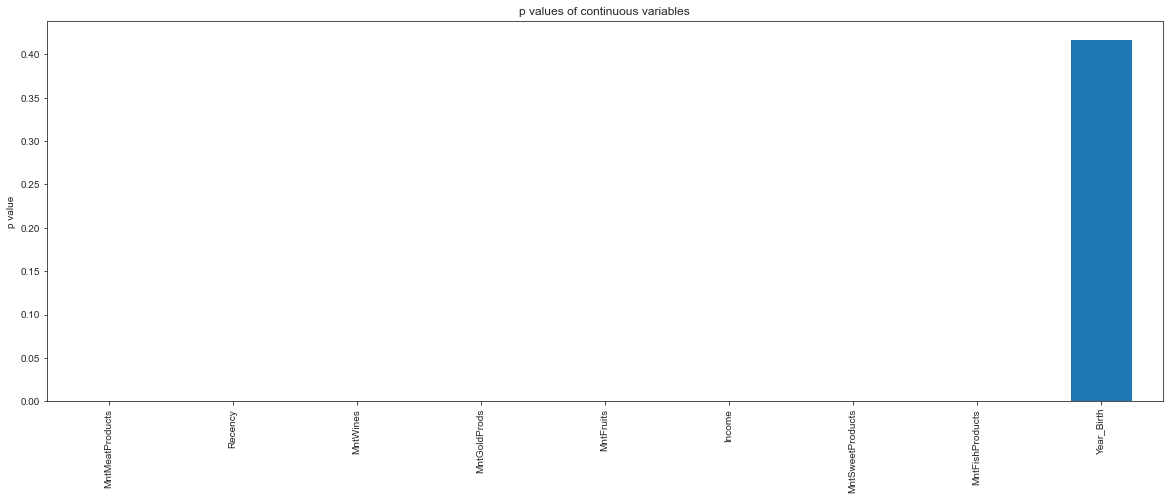

In [21]:
# plot out the p values for the t-test
p_ls_mann = pd.Series(p_ls_mann)
p_ls_mann.sort_values(ascending=True).plot.bar(figsize=(20,7))
plt.title('p values of continuous variables')
plt.ylabel('p value')

In [22]:
p_ls_mann.sort_values(ascending=True)

MntMeatProducts     3.541361e-17
Recency             3.262949e-15
MntWines            3.492536e-14
MntGoldProds        3.280502e-11
MntFruits           1.765986e-08
Income              3.726926e-08
MntSweetProducts    9.720058e-08
MntFishProducts     1.261379e-04
Year_Birth          4.176640e-01
dtype: float64

All the variables suggest a statistical difference in sample means and a rejection of the null hypothesis at the 5% significance level except Year_Birth.

Let's compute the effect sizes and see how important these variables are:

In [23]:
# distribution-free effect size

def mw_effect_size(df, var, target):
    
    # separate the two samples
    data_1 = df[df[target]==0][var]
    data_2 = df[df[target]==1][var] 
    
    # grab the p value and the test statistic
    U1, p = mannwhitneyu(data_1, data_2)
    nx, ny = len(data_1), len(data_2)
    
    # calculate the z score
    U2 = (nx*ny) - U1
    U = min(U1, U2)
    N = nx + ny
    z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
    
    # compute the effect size
    r = z / np.sqrt(N)
    return r

In [24]:
# empty dictionary to store the sizes
continuous_effects = {}

# iterate over each variable
for var in cont_vars:
    
    # store the size and variable name in the dictionary
    size = mw_effect_size(train, var, 'Response')
    continuous_effects[var] = abs(size)

Text(0, 0.5, 'effect size')

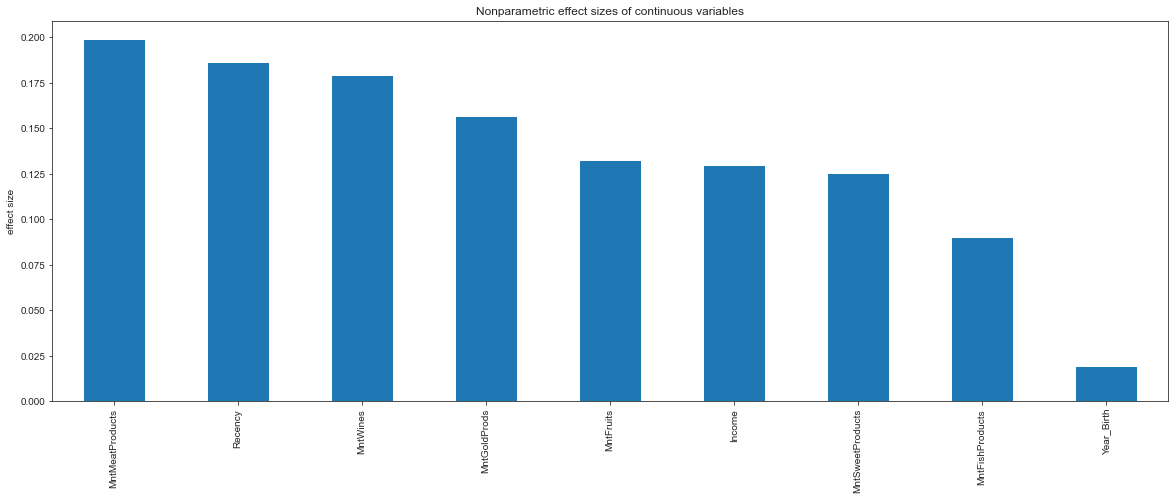

In [25]:
# plot out the sizes in ascending order
continuous_effects = pd.Series(continuous_effects)
continuous_effects.sort_values(ascending=False).plot.bar(figsize=(20,7))
plt.title('Nonparametric effect sizes of continuous variables')
plt.ylabel('effect size')

In [26]:
continuous_effects.sort_values(ascending=False)

MntMeatProducts     0.199063
Recency             0.186146
MntWines            0.179024
MntGoldProds        0.156675
MntFruits           0.132637
Income              0.130004
MntSweetProducts    0.125486
MntFishProducts     0.090272
Year_Birth          0.019139
dtype: float64

All the effect sizes are less than 0.3 which suggests the variables have small effects. This isn't very suprising- recall that we observed during data analysis that the distributions of the samples all looked like they shared the same range from the eye-test. We asserted that this could either mean the samples came from the same distribution or the effect sizes would be immaterial if the p-values violated the null hypothesis.

We will go ahead and just select the binary variables with p <= 0.5 and with medium effects for our model. Essentially, these are the variables that inform us on the customer's decisions from previous campaigns.

In [27]:
selected_features = [var for var in binary_effects.keys() if binary_effects[var] > 0.0]
selected_features

['AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2']

In [28]:
# save our selected features for the next notebook
pd.Series(selected_features).to_csv('selected_features.csv', index=False)